In [1]:
# Run this cell first to import all modules and run all of the needed functions
# The simulation variables can be set in the next cell
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import p1simulation as sim
import time
import scipy
from scipy import stats


def plot_array(sys_array): # Give it a sys_array, and it will plot the configuraton
    
    %matplotlib inline
    host_sites = np.where(sys_array == 1)
    hx,hy,hz = host_sites
    species_sites = np.where(sys_array != 1)
    sx,sy,sz = species_sites
    
    if 2 in sx:
        species == 'atoms'
    else:
        species == 'vacancy'
        
    fig = plt.figure()
    ax1 = plt.subplot(111, projection='3d')
    ax1.scatter(hx,hy,hz, zdir='z', c= 'r',s=5)
    if species != 'vacancy':
        ax1.scatter(sx,sy,sz, zdir='z', c= 'b',s=15)
    ax1.grid(False)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_zticks([])
    plt.show();

    
def plot_data(x, y, title, xaxis, yaxis):  # General plotting func, pass in an array/list of data for x and y
    
    %matplotlib inline
    if x == 'steps':
        x = range(0,steps)
    fig = plt.figure()
    plt.plot(x,y)
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    plt.title(title)
    plt.show()

    
def heat_capacity(Tstart, Tend, sample_num, conc):
    # Func to run a heat capacity simulation. - ONLY SEEMS TO WORK WITH VACANCIES
    # Goal is to put in the starting and ending temp - and how many data points you want in that range (Tnum)
    # Func will run a sim at each temp, collect the avg PE from that sim (from the indepent samples)
    # Create a plot of Avg PE per N, vs Temp
    # Find the slop of the plot to give the heat capacity (dPE/dT)
    X = conc
    Tstep = (Tend - Tstart)/sample_num
    Temps = np.arange(Tstart, Tend, Tstep)
    print('Temperatures of each simulation: {}'.format(Temps))
    if species == 'atoms' or species == 'atom':
        N = D**3
    elif species != 'atoms' or species != 'atom':
        N = int((D**3) * float((1-X)))  # Total number of particles is a func of vac concentration
    
    UList = []  # List of average energies per particle for each Temp
    for T in Temps:
        U_list, initial_array, final_array, moves = sim.run_simulation(steps, species, D, X, mixed, T)
        auto_corr, increment = autocorr1D(U_list)
        ind_sample_list = U_list[::-increment]
        U_average = np.mean(ind_sample_list)
        U_particle_avg = U_average/N
        UList.append(U_particle_avg)
    
    # Find the slope between each of the data points
    slope_values = []
    slope_temps = []
    for i in range(1,len(Temps)):
        deltaY = float(UList[i] - UList[i-1])
        deltaX = float(Temps[i] - Temps[i-1])
        slope = round(deltaY/deltaX,2)
        slope_values.append(slope)
        slope_temps.append((Temps[i] + Temps[i-1])/2)
    
    %matplotlib inline
    color = 'b'
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Temperature')
    ax1.set_ylabel('Avg. PE per Particle', color=color)
    ax1.plot(Temps, UList, 'o-',color=color)
    ax1.tick_params(axis='y', color=color)
    
    color = 'r'
    ax2 = ax1.twinx()
    ax2.set_ylabel('Heat Capacity', color=color)
    ax2.plot(slope_temps,slope_values,'^', color=color)
    ax2.tick_params(axis='y',color=color)
    for j, k in zip(slope_temps,slope_values):
        ax2.annotate(str(k),xy=(j+.03,k))
    fig.tight_layout()
    plt.show()
      
    return UList, slope_values, Temps

def concentration(Tstart, Tend):
    
    conc = [0.1, 0.25, 0.5, 0.75]
    
    sample_num = 2
    heat_cap = []
    for i in conc:
        UList, cv, Temps = heat_capacity(Tstart, Tend, sample_num, i)
        heat_cap.append(cv)
    
    plt.plot(conc,heat_cap)
    plt.title("Concentration Experiment: Heat Capacity vs. Conc", color = 'g')
    plt.xlabel("Concentration (2nd Species)")
    plt.ylabel("Heat Capacity")
    plt.show()
    
def autocorr1D(array):
    '''Takes in a linear numpy array, performs autocorrelation
       function and returns normalized array with half the length 
       of the input'''
    ft = np.fft.rfft(array-np.average(array)) 
    acorr = np.fft.irfft(ft*np.conjugate(ft))/(len(array)*np.var(array))
    
    index = 0  # The value of index will be our incremental step value for sampling from data sets of PE, etc..
    for value in acorr[0:len(acorr)//2]:
        if value > 0:
            index = index + 1
        elif value <= 0:
            break
        
    return acorr[0:len(acorr)//2], index


def pbc(d,L):
    return d - L * ((d+L/2)//L)


def rdf(sys_array, species, dr):
    Ntot = D**3
    if species == 'atoms' or species == 'vacancy':
        N = Ntot * X
    elif species == 'host':
        N = Ntot * (1-X)
    dmax = D/2
    nbins = int(dmax//dr)
    coordinates, sites = sim.site_coordinates(sys_array, species)
    bins = np.zeros(nbins)
    r = np.array([i*dr for i in range(nbins)])
    for i, coord in enumerate(coordinates[:-2]): # i is index and coord is coordinate
        for n in coordinates[i+1:]:
            site1 = coord
            site2 = n
            dist1 = ((site2[0]-site1[0])**2+(site2[1]-site1[1])**2+(site2[2]-site1[2])**2)**(1/2)
            dist = pbc(dist1,D)
            bin_index = int(np.absolute(dist//dr))
            if bin_index<nbins:
                bins[bin_index] += 1
    for i, b in enumerate(bins):
        bins[i] /= N*(N-1)*np.pi*(2*(i+1)*dr**2)/(2*D**3)
    %matplotlib inline
    rdf_fig = plt.figure()
    #plt.bar(r, bins)
    plt.plot(r,bins)
    plt.title('Radial Distribution Function')
    plt.xlabel('Distance')
    plt.ylabel('Frequency')
    plt.show()

In [2]:
# Define the global parameters of your system:


steps = 10000        # If D = 10 then 10,000 steps takes about 12 seconds.
T = 0.75            # T for a single sim.  A range of temps can be set when you call the heat_capacity func
species = 'atoms'   # 'atoms' or 'vacancies'
D = 10              # Edge length of the system. Total # of particles = D^3
X = 0.30            # The concentration of the species (atoms or vacancies).  Multiple of D^3
mixed = 'n'         # If species = atoms, you can chose unmixed initial config. Vacancies are always mixed
dr = 0.01            # Bin length for RDF function

Running Simulaton...
Simulation Complete:
Computation time = 14.09 s
Ratio of accepted moves = 0.3827


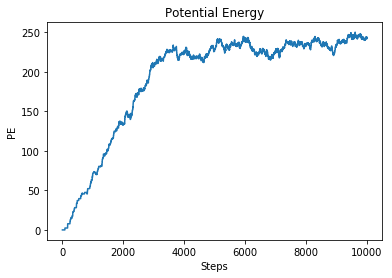

In [3]:
# Run a single simulation using the above variables.  Plots the PE vs Steps graph
U_list, initial_array, final_array, moves = sim.run_simulation(steps, species, D, X, mixed, T, sys_array = 'new')
x = range(0,steps)
plot_data(x, U_list, title='Potential Energy', xaxis = 'Steps', yaxis = 'PE')

Initial Configuration:


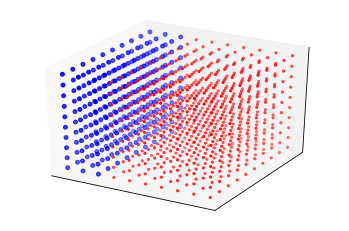

In [4]:
# View the initial and final configurations after the simulation in these next 2 cells

print('Initial Configuration:')
plot_array(sys_array = initial_array)

Final Configuration:


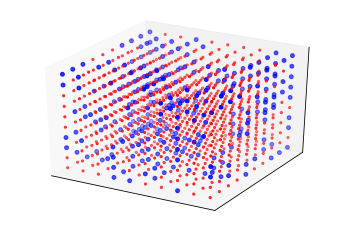

In [5]:
print('Final Configuration:')
plot_array(sys_array = final_array)

Temperatures of each simulation: [0.5 0.7 0.9 1.1 1.3]
Running Simulaton...
Simulation Complete:
Computation time = 15.13 s
Ratio of accepted moves = 0.0419
Running Simulaton...
Simulation Complete:
Computation time = 13.42 s
Ratio of accepted moves = 0.3162
Running Simulaton...
Simulation Complete:
Computation time = 13.43 s
Ratio of accepted moves = 0.479
Running Simulaton...
Simulation Complete:
Computation time = 13.68 s
Ratio of accepted moves = 0.61
Running Simulaton...
Simulation Complete:
Computation time = 13.25 s
Ratio of accepted moves = 0.6753


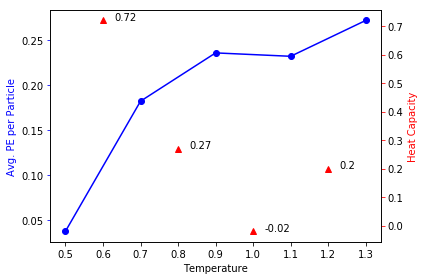

In [6]:
# Heat Capacity Experiment:

#Set your range of temperatures (Tstart --> Tend)
#Set how many data points you want within that range (sample_num)
#If D = 10 and steps =  10,000: 5 sample points takes about 1 min


Ulist, slopes, Temps = heat_capacity(Tstart = .5, Tend = 1.5, sample_num = 5, conc = X)

# This function is used when finding the change in entropy between 2 temperatures.

Finding the heat capacity...
Temperatures of each simulation: [0.5 0.7 0.9 1.1 1.3]
Running Simulaton...
Simulation Complete:
Computation time = 13.71 s
Ratio of accepted moves = 0.1573
Running Simulaton...
Simulation Complete:
Computation time = 13.70 s
Ratio of accepted moves = 0.4158
Running Simulaton...
Simulation Complete:
Computation time = 13.51 s
Ratio of accepted moves = 0.5714
Running Simulaton...
Simulation Complete:
Computation time = 13.59 s
Ratio of accepted moves = 0.6593
Running Simulaton...
Simulation Complete:
Computation time = 13.49 s
Ratio of accepted moves = 0.7243


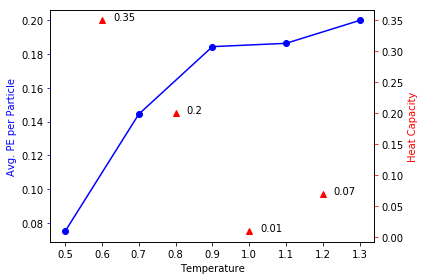

Cv as a function of temperature:
Best fit coefficients = [1.31, -2.61, 1.34]
Cv(T) = 1.31 + -2.61T + 1.34T^2
The change in entropy from T = 0.5 to T = 1.5 is 0.17


In [3]:
# Quantify the change in entropy of the system with respect to a change in temperature:
'''
First - The heat capacity is calculated using the heat_capacity function.
We used the method to find the change in energy with respect to the change in temperature.
A simulation is ran for each temperature, and the average change in energy is plotted.
The slope (dU/dT) is the heat capacity.  Since the heat capacity is itself a function of temperature,
we find the slope between each set of data points.  The resulting values of Cv can then be modeled as a function 
of temperature.

Finding change in entropy of the sytem:
dS/dT = Cv/T  --> deltaS = integral(Cv/T)dt --> Cv is plotted as a function of T (heat capcity function)
                                               Use numpy polyfit to obtain the coefficients of Cv(T)
                                               Cv(T) = a + bT + cT^2
                                            
The units of entropy returned are dimensionless (using our dimensionless temperature values), but we can examine the 
magnitudes of deltaS given different system parameters.
'''

def deltaEntropy(Tstart, Tend, sample_num):
    print('Finding the heat capacity...')
    Ulist, slopes, Temps = heat_capacity(Tstart = .5, Tend = 1.5, sample_num = 5, conc = X)
    CvT = np.polyfit(Temps[0:-1], slopes, deg = 2) # returns 3 coefficients of heat capacit as a func of T
    CvT = [round(i,2) for i in CvT]
    print('Cv as a function of temperature:')
    print('Best fit coefficients = {}'.format(CvT))
    print('Cv(T) = {} + {}T + {}T^2'.format(CvT[0],CvT[1],CvT[2]))
    deltaS = (CvT[0]*np.log(Tend/Tstart)) + (CvT[1]*(Tend - Tstart)) + ((CvT[2] * (Tend**2 - Tstart**2))/2)
    deltaS = round(deltaS,2)
    print('The change in entropy from T = {} to T = {} is {}'.format(Tstart,Tend,deltaS))
    
    return deltaS

deltaS = deltaEntropy(Tstart = 0.5, Tend = 1.5, sample_num = 5)


Temperatures of each simulation: [ 0.5  1. ]
Running Simulaton...
Simulation Complete:
Computation time = 5.64 s
Ratio of accepted moves = 0.3208
Running Simulaton...
Simulation Complete:
Computation time = 5.70 s
Ratio of accepted moves = 0.7434


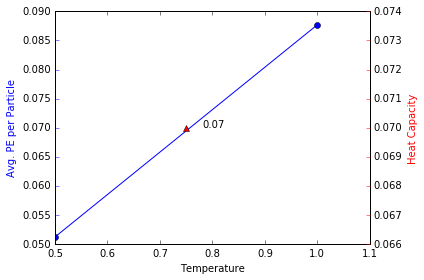

Temperatures of each simulation: [ 0.5  1. ]
Running Simulaton...
Simulation Complete:
Computation time = 5.84 s
Ratio of accepted moves = 0.0835
Running Simulaton...
Simulation Complete:
Computation time = 5.82 s
Ratio of accepted moves = 0.5888


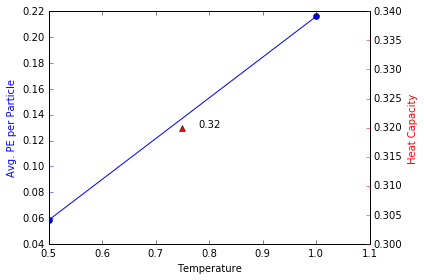

Temperatures of each simulation: [ 0.5  1. ]
Running Simulaton...
Simulation Complete:
Computation time = 5.80 s
Ratio of accepted moves = 0.0479
Running Simulaton...
Simulation Complete:
Computation time = 6.36 s
Ratio of accepted moves = 0.4827


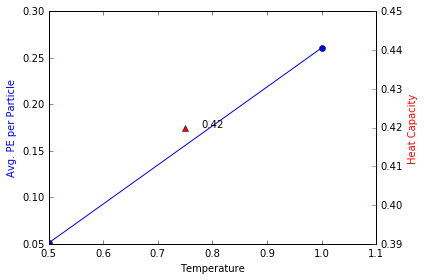

Temperatures of each simulation: [ 0.5  1. ]
Running Simulaton...
Simulation Complete:
Computation time = 5.93 s
Ratio of accepted moves = 0.0831
Running Simulaton...
Simulation Complete:
Computation time = 5.88 s
Ratio of accepted moves = 0.6


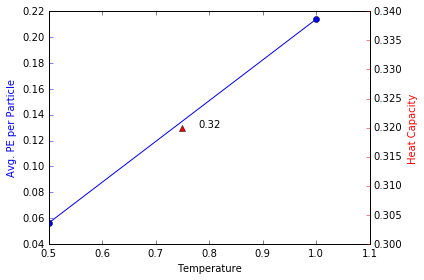

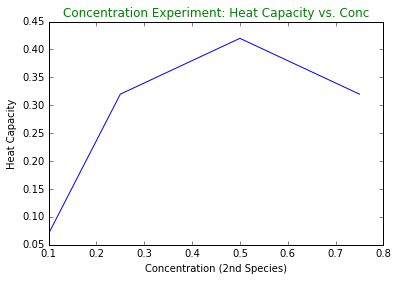

In [7]:
# Concentration Experiment

concentration(Tstart = .5, Tend = 1.5)

RDF OF THE HOST ATOMS
----------------
Initial Configuration:


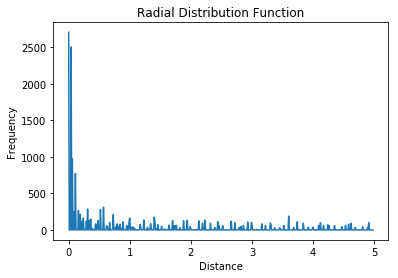

Final Configuration:


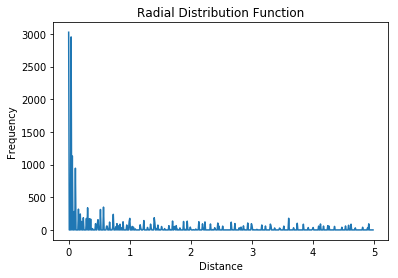


RDF OF THE SPECIES
----------------
Initial Configuration:


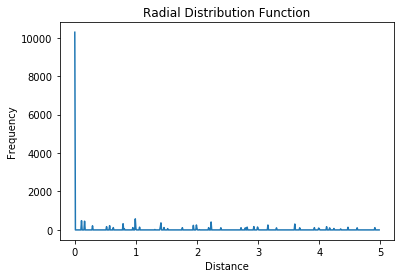

Final Configuration:


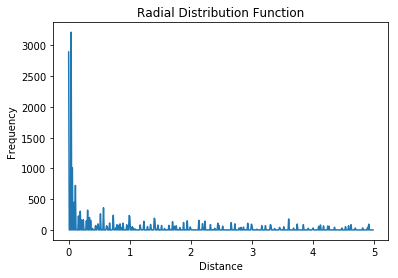

In [8]:
# This cell plots the RDF of the host atoms and species atoms/vacancies separately
# Plots the RDF before and after the simulation

print('RDF OF THE HOST ATOMS')
print('----------------')
print('Initial Configuration:')
rdf(initial_array, 'host', dr)
print('Final Configuration:')
rdf(final_array, 'host', dr)

print()

print('RDF OF THE SPECIES')
print('----------------')
print('Initial Configuration:')
rdf(initial_array, species, dr)
print('Final Configuration:')
rdf(final_array, species, dr)
